# Preprocessing and Training

In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score, mean_absolute_error, mean_squared_error
import joblib


In [17]:
# Load the dataset (replace 'Data.csv' with your file path)
file_path = "material.csv"
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("Dataset Loaded Successfully!")
data.head()


Dataset Loaded Successfully!


,Material,Su,Sy,E,G,mu,Ro,Use
0,ANSI Steel SAE 1015 as-rolled,421,314,207000,79000,0.3,7860,True
1,ANSI Steel SAE 1015 normalized,424,324,207000,79000,0.3,7860,True
2,ANSI Steel SAE 1015 annealed,386,284,207000,79000,0.3,7860,True
3,ANSI Steel SAE 1020 as-rolled,448,331,207000,79000,0.3,7860,True
4,ANSI Steel SAE 1020 normalized,441,346,207000,79000,0.3,7860,True


In [18]:
# Select relevant columns
selected_columns = [ 'Su', 'Sy', 'E', 'G', 'mu', 'Ro', 'Use']
df = data[selected_columns]

# Rename columns for better readability
df.columns = [ 'Ultimate_Tensile_Strength', 'Yield_Strength', 
              'Elastic_Modulus', 'Shear_Modulus', 
              'Poissons_Ratio', 'Density', 'Use']

# Display summary of selected data
print(f"Selected {len(selected_columns)} columns.")
df.head()


Selected 7 columns.


,Ultimate_Tensile_Strength,Yield_Strength,Elastic_Modulus,Shear_Modulus,Poissons_Ratio,Density,Use
0,421,314,207000,79000,0.3,7860,True
1,424,324,207000,79000,0.3,7860,True
2,386,284,207000,79000,0.3,7860,True
3,448,331,207000,79000,0.3,7860,True
4,441,346,207000,79000,0.3,7860,True


In [19]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values)

# Drop rows with missing values (or use imputation if necessary)
df_cleaned = df.dropna()

print(f"Rows before cleaning: {len(df)}")
print(f"Rows after cleaning: {len(df_cleaned)}")


Missing Values per Column:
Ultimate_Tensile_Strength    0
Yield_Strength               0
Elastic_Modulus              0
Shear_Modulus                0
Poissons_Ratio               0
Density                      0
Use                          0
dtype: int64
Rows before cleaning: 1552
Rows after cleaning: 1552


Summary Statistics:
       Ultimate_Tensile_Strength  Yield_Strength  Elastic_Modulus  \
count                1552.000000     1552.000000      1552.000000   
mean                  572.753222      387.010309    164571.520619   
std                   326.834927      289.482497     56135.405867   
min                    69.000000       28.000000     73000.000000   
25%                   340.000000      205.000000    105000.000000   
50%                   500.000000      305.000000    206000.000000   
75%                   705.000000      470.000000    206000.000000   
max                  2220.000000     2048.000000    219000.000000   

       Shear_Modulus  Poissons_Ratio      Density  
count    1552.000000     1552.000000  1552.000000  
mean    85598.840206        0.302977  6929.843428  
std    125326.800138        0.024590  2115.171710  
min     26000.000000        0.200000  1750.000000  
25%     40000.000000        0.300000  7160.000000  
50%     79000.000000        0.300000  7860.000

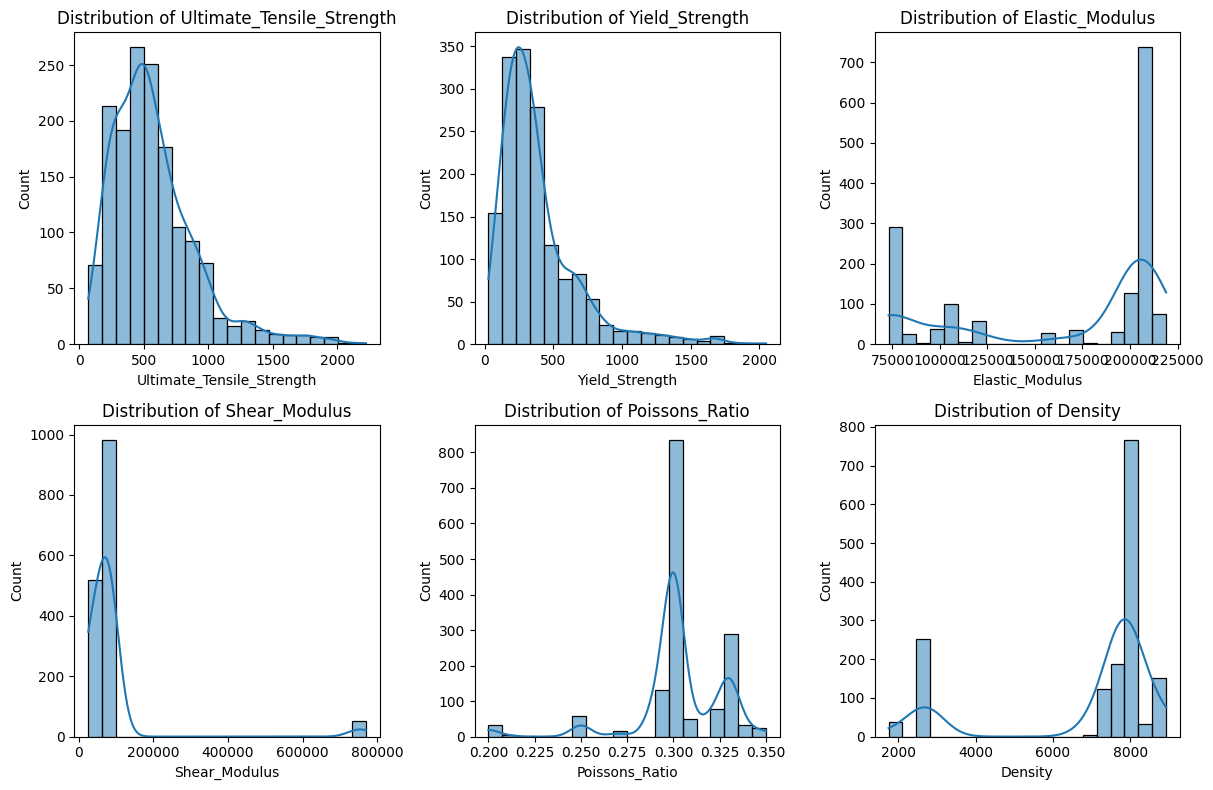

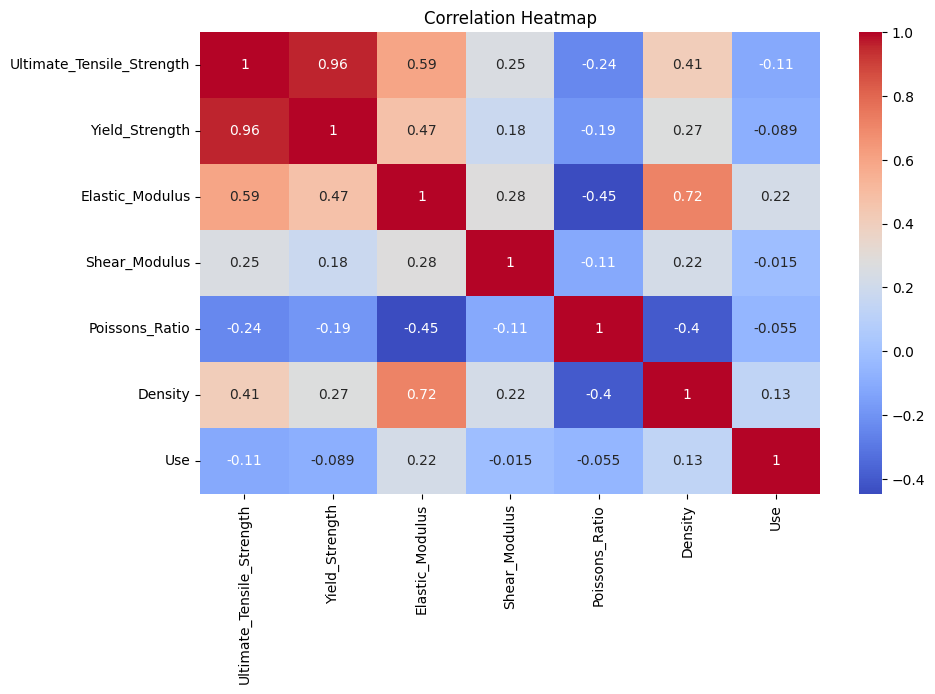

In [20]:
# Summary statistics for numerical columns
print("Summary Statistics:")
print(df_cleaned.describe())

# Visualize distributions of numerical features
numerical_features = ['Ultimate_Tensile_Strength', 'Yield_Strength', 
                      'Elastic_Modulus', 'Shear_Modulus', 
                      'Poissons_Ratio', 'Density']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(numerical_features):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_cleaned[feature], kde=True, bins=20)
    plt.title(f"Distribution of {feature}")
plt.tight_layout()
plt.show()

# Correlation heatmap to check relationships between features
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [21]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode target variable ('Use') into binary format (Yes=1, No=0)
label_encoder = LabelEncoder()
df_cleaned['Use'] = label_encoder.fit_transform(df_cleaned['Use'])

# Scale numerical features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cleaned[numerical_features])

# Create final preprocessed DataFrame
df_preprocessed = pd.DataFrame(scaled_features, columns=numerical_features)
df_preprocessed['Use'] = df_cleaned['Use'].values

print("Preprocessing Complete!")
df_preprocessed.head()


Preprocessing Complete!


,Ultimate_Tensile_Strength,Yield_Strength,Elastic_Modulus,Shear_Modulus,Poissons_Ratio,Density,Use
0,-0.464461,-0.252291,0.756067,-0.05267,-0.121096,0.439896,1
1,-0.455279,-0.217736,0.756067,-0.05267,-0.121096,0.439896,1
2,-0.571583,-0.355958,0.756067,-0.05267,-0.121096,0.439896,1
3,-0.381824,-0.193547,0.756067,-0.05267,-0.121096,0.439896,1
4,-0.403248,-0.141713,0.756067,-0.05267,-0.121096,0.439896,1


In [22]:
data = df_preprocessed

In [23]:
# Define a function to evaluate classification models
def evaluate_classification_model(model, X_train, y_train):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=kfold)
    return scores.mean(), scores.std()

# Define a function to evaluate regression models
def evaluate_regression_model(model, X_train, y_train):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=kfold)
    return scores.mean(), scores.std()

# Function to save the best model and scaler
def save_model_and_scaler(pipeline, filename_model, filename_scaler):
    scaler = pipeline.named_steps['scaler']
    model = pipeline.named_steps['model']
    joblib.dump(scaler, filename_scaler)
    joblib.dump(model, filename_model)
    print(f"Model saved as {filename_model} and scaler saved as {filename_scaler}")

In [25]:
### Task 1: Material Suitability Classification ###
print("\n--- Task 1: Material Suitability Classification ---")
features_suitability = ['Ultimate_Tensile_Strength', 'Yield_Strength', 'Elastic_Modulus',
                        'Shear_Modulus', 'Poissons_Ratio', 'Density']
target_suitability = 'Use'

X_suitability = data[features_suitability]
y_suitability = data[target_suitability].apply(lambda x: 1 if x else 0)

X_train_suitability, X_test_suitability, y_train_suitability, y_test_suitability = train_test_split(
    X_suitability, y_suitability, test_size=0.3, random_state=42)

# Try multiple classification models
classification_models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

classification_results = {}
for name, model in classification_models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train_suitability, y_train_suitability)
    
    # Evaluate on test data
    y_pred = pipeline.predict(X_test_suitability)
    accuracy = accuracy_score(y_test_suitability, y_pred)
    precision = precision_score(y_test_suitability, y_pred)
    recall = recall_score(y_test_suitability, y_pred)
    f1 = f1_score(y_test_suitability, y_pred)
    
    classification_results[name] = {"Accuracy": accuracy, "Precision": precision,
                                     "Recall": recall, "F1-Score": f1}
    
# Print metrics for all models
print("Classification Metrics:")
for model_name, metrics in classification_results.items():
    print(f"{model_name}: {metrics}")

# Select the best classification model based on F1-Score
best_classification_model_name = max(classification_results,
                                     key=lambda x: classification_results[x]["F1-Score"])
best_classification_model = classification_models[best_classification_model_name]

# Save the best model and scaler
pipeline_best_classification = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_classification_model)
])
pipeline_best_classification.fit(X_train_suitability, y_train_suitability)

save_model_and_scaler(pipeline_best_classification,
                      "suitability_model.pkl",
                      "suitability_scaler.pkl")



--- Task 1: Material Suitability Classification ---
Classification Metrics:
Logistic Regression: {'Accuracy': 0.9163090128755365, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}
Decision Tree: {'Accuracy': 0.9978540772532188, 'Precision': 1.0, 'Recall': 0.9666666666666667, 'F1-Score': 0.9830508474576272}
Random Forest: {'Accuracy': 0.9978540772532188, 'Precision': 1.0, 'Recall': 0.9666666666666667, 'F1-Score': 0.9830508474576272}
Gradient Boosting: {'Accuracy': 0.9978540772532188, 'Precision': 1.0, 'Recall': 0.9666666666666667, 'F1-Score': 0.9830508474576272}
Model saved as suitability_model.pkl and scaler saved as suitability_scaler.pkl


In [26]:
### Task 2: Ultimate Tensile Strength Prediction ###
print("\n--- Task 2: Ultimate Tensile Strength Prediction ---")
features_strength = ['Yield_Strength', 'Elastic_Modulus', 'Shear_Modulus',
                     'Poissons_Ratio', 'Density']
target_strength = 'Ultimate_Tensile_Strength'

X_strength = data[features_strength]
y_strength = data[target_strength]

X_train_strength, X_test_strength, y_train_strength, y_test_strength = train_test_split(
    X_strength, y_strength, test_size=0.3, random_state=42)

# Try multiple regression models
regression_models_strength = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

regression_results_strength = {}
for name, model in regression_models_strength.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train_strength, y_train_strength)
    
    # Evaluate on test data
    y_pred = pipeline.predict(X_test_strength)
    r2 = r2_score(y_test_strength, y_pred)
    mae = mean_absolute_error(y_test_strength, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_strength, y_pred))
    
    regression_results_strength[name] = {"R² Score": r2, "MAE": mae, "RMSE": rmse}

# Print metrics for all models
print("Regression Metrics for Ultimate Tensile Strength:")
for model_name, metrics in regression_results_strength.items():
    print(f"{model_name}: {metrics}")

# Select the best regression model based on R² Score
best_regression_model_name = max(regression_results_strength,
                                 key=lambda x: regression_results_strength[x]["R² Score"])
best_regression_model = regression_models_strength[best_regression_model_name]

# Save the best model and scaler
pipeline_best_regression = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_regression_model)
])
pipeline_best_regression.fit(X_train_strength, y_train_strength)

save_model_and_scaler(pipeline_best_regression,
                      "tensile_strength_model.pkl",
                      "tensile_strength_scaler.pkl")



--- Task 2: Ultimate Tensile Strength Prediction ---
Regression Metrics for Ultimate Tensile Strength:
Linear Regression: {'R² Score': 0.9513315561345671, 'MAE': 0.17457886667685882, 'RMSE': np.float64(0.22359440383045032)}
Decision Tree Regressor: {'R² Score': 0.9491201026154197, 'MAE': 0.15283369223402699, 'RMSE': np.float64(0.22861794307138136)}
Random Forest Regressor: {'R² Score': 0.962623908050598, 'MAE': 0.1390480865313137, 'RMSE': np.float64(0.19594498125822035)}
Gradient Boosting Regressor: {'R² Score': 0.9655705865476607, 'MAE': 0.14076473198889536, 'RMSE': np.float64(0.18806241622503772)}
Model saved as tensile_strength_model.pkl and scaler saved as tensile_strength_scaler.pkl


In [27]:
### Task 3: Shear Modulus Prediction ###
print("\n--- Task 3: Shear Modulus Prediction ---")
features_modulus = ['Ultimate_Tensile_Strength', 'Yield_Strength', 'Elastic_Modulus',
                    'Poissons_Ratio', 'Density']
target_modulus = 'Shear_Modulus'

X_modulus = data[features_modulus]
y_modulus = data[target_modulus]

X_train_modulus, X_test_modulus, y_train_modulus, y_test_modulus = train_test_split(
    X_modulus, y_modulus, test_size=0.3, random_state=42)

# Try multiple regression models
regression_models_modulus = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

regression_results_modulus = {}
for name, model in regression_models_modulus.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train_modulus, y_train_modulus)
    
    # Evaluate on test data
    y_pred = pipeline.predict(X_test_modulus)
    r2 = r2_score(y_test_modulus, y_pred)
    mae = mean_absolute_error(y_test_modulus, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_modulus, y_pred))
    
    regression_results_modulus[name] = {"R² Score": r2, "MAE": mae, "RMSE": rmse}

# Print metrics for all models
print("Regression Metrics for Shear Modulus:")
for model_name, metrics in regression_results_modulus.items():
    print(f"{model_name}: {metrics}")

# Select the best regression model based on R² Score
best_regression_model_name_modulus = max(regression_results_modulus,
                                         key=lambda x: regression_results_modulus[x]["R² Score"])
best_regression_model_modulus = regression_models_modulus[best_regression_model_name_modulus]

# Save the best model and scaler
pipeline_best_regression_modulus = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_regression_model_modulus)
])
pipeline_best_regression_modulus.fit(X_train_modulus, y_train_modulus)

save_model_and_scaler(pipeline_best_regression_modulus,
                      "shear_modulus_model.pkl",
                      "shear_modulus_scaler.pkl")



--- Task 3: Shear Modulus Prediction ---
Regression Metrics for Shear Modulus:
Linear Regression: {'R² Score': 0.0954840977164001, 'MAE': 0.3511081856512729, 'RMSE': np.float64(0.7781854263457977)}
Decision Tree Regressor: {'R² Score': 0.8044249173365048, 'MAE': 0.02395541039496762, 'RMSE': np.float64(0.3618526447006584)}
Random Forest Regressor: {'R² Score': 0.8044307377767473, 'MAE': 0.023849558517203637, 'RMSE': np.float64(0.36184726017688207)}
Gradient Boosting Regressor: {'R² Score': 0.804478904510688, 'MAE': 0.024169209479351295, 'RMSE': np.float64(0.3618026977702215)}
Model saved as shear_modulus_model.pkl and scaler saved as shear_modulus_scaler.pkl


In [28]:
### Task 4: Density Prediction ###
print("\n--- Task 4: Density Prediction ---")
features_density = ['Ultimate_Tensile_Strength', 'Yield_Strength', 'Elastic_Modulus',
                    'Shear_Modulus', 'Poissons_Ratio']
target_density = 'Density'

X_density = data[features_density]
y_density = data[target_density]

X_train_density, X_test_density, y_train_density, y_test_density = train_test_split(
    X_density, y_density, test_size=0.3, random_state=42)

# Try multiple regression models
regression_models_density = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(random_state=42),
    "Random Forest Regressor": RandomForestRegressor(random_state=42),
    "Gradient Boosting Regressor": GradientBoostingRegressor(random_state=42)
}

regression_results_density = {}
for name, model in regression_models_density.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])
    pipeline.fit(X_train_density, y_train_density)
    
    # Evaluate on test data
    y_pred = pipeline.predict(X_test_density)
    r2 = r2_score(y_test_density, y_pred)
    mae = mean_absolute_error(y_test_density, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_density, y_pred))
    
    regression_results_density[name] = {"R² Score": r2, "MAE": mae, "RMSE": rmse}

# Print metrics for all models
print("Regression Metrics for Density:")
for model_name, metrics in regression_results_density.items():
    print(f"{model_name}: {metrics}")

# Select the best regression model based on R² Score
best_regression_model_name_density = max(regression_results_density,
                                         key=lambda x: regression_results_density[x]["R² Score"])
best_regression_model_density = regression_models_density[best_regression_model_name_density]

# Save the best model and scaler
pipeline_best_regression_density = Pipeline([
    ('scaler', StandardScaler()),
    ('model', best_regression_model_density)
])
pipeline_best_regression_density.fit(X_train_density, y_train_density)

save_model_and_scaler(pipeline_best_regression_density,
                      "density_model.pkl",
                      "density_scaler.pkl")



--- Task 4: Density Prediction ---
Regression Metrics for Density:
Linear Regression: {'R² Score': 0.5795434408757862, 'MAE': 0.4722656660781077, 'RMSE': np.float64(0.6805764321887928)}
Decision Tree Regressor: {'R² Score': 0.9931571439287524, 'MAE': 0.02126920916054894, 'RMSE': np.float64(0.08682305088938233)}
Random Forest Regressor: {'R² Score': 0.9941661929539849, 'MAE': 0.02647824255727514, 'RMSE': np.float64(0.08016639793413635)}
Gradient Boosting Regressor: {'R² Score': 0.9944078335616982, 'MAE': 0.029048171734952517, 'RMSE': np.float64(0.07848856413284191)}
Model saved as density_model.pkl and scaler saved as density_scaler.pkl


In [15]:

print("\nAll tasks completed! Models and scalers have been trained and saved successfully.")



All tasks completed! Models and scalers have been trained and saved successfully.
